In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import os
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree
import matplotlib as mpl
import cma
#help(cma.CMAEvolutionStrategy)

In [2]:
import os
import sys
import time
import numpy as np
import math
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage.measure
import plyfile
from plyfile import PlyData
from sklearn.neighbors import KDTree
import trimesh
#import torch_geometric
#from torch_geometric.nn import (NNConv, GMMConv, GraphConv, Set2Set)
#from torch_geometric.nn import (SplineConv, graclus, max_pool, max_pool_x, global_mean_pool)
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [3]:
from abc import ABC, abstractmethod

class objective_func(ABC):
    @abstractmethod
    def func(self, x):
        pass
    def dfunc(self, x):
        out = self.func(x)
        out.backward()
        return x.grad
    def get_optimal(self):
        return self.optimal
    def get_optimum(self):
        return self.optimum
    

class Decoder(nn.Module):
    def __init__(
        self,
        latent_size,
        dims,
        dropout=None,
        dropout_prob=0.0,
        norm_layers=(),
        latent_in=(),
        weight_norm=False,
        xyz_in_all=None,
        use_tanh=False,
        latent_dropout=False,
    ):
        super(Decoder, self).__init__()

        def make_sequence():
            return []

        dims = [latent_size + 3] + dims + [1]

        self.num_layers = len(dims)
        self.norm_layers = norm_layers
        self.latent_in = latent_in
        self.latent_dropout = latent_dropout
        if self.latent_dropout:
            self.lat_dp = nn.Dropout(0.2)

        self.xyz_in_all = xyz_in_all
        self.weight_norm = weight_norm

        for layer in range(0, self.num_layers - 1):
            if layer + 1 in latent_in:
                out_dim = dims[layer + 1] - dims[0]
            else:
                out_dim = dims[layer + 1]
                if self.xyz_in_all and layer != self.num_layers - 2:
                    out_dim -= 3

            if weight_norm and layer in self.norm_layers:
                setattr(
                    self,
                    "lin" + str(layer),
                    nn.utils.weight_norm(nn.Linear(dims[layer], out_dim)),
                )
            else:
                setattr(self, "lin" + str(layer), nn.Linear(dims[layer], out_dim))

            if (
                (not weight_norm)
                and self.norm_layers is not None
                and layer in self.norm_layers
            ):
                setattr(self, "bn" + str(layer), nn.LayerNorm(out_dim))

        self.use_tanh = use_tanh
        if use_tanh:
            self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

        self.dropout_prob = dropout_prob
        self.dropout = dropout
        self.th = nn.Tanh()

    # input: N x (L+3)
    def forward(self, input):
        xyz = input[:, -3:]

        if input.shape[1] > 3 and self.latent_dropout:
            latent_vecs = input[:, :-3]
            latent_vecs = F.dropout(latent_vecs, p=0.2, training=self.training)
            x = torch.cat([latent_vecs, xyz], 1)
        else:
            x = input

        for layer in range(0, self.num_layers - 1):
            lin = getattr(self, "lin" + str(layer))
            if layer in self.latent_in:
                x = torch.cat([x, input], 1)
            elif layer != 0 and self.xyz_in_all:
                x = torch.cat([x, xyz], 1)
            x = lin(x)
            # last layer Tanh
            if layer == self.num_layers - 2 and self.use_tanh:
                x = self.tanh(x)
            if layer < self.num_layers - 2:
                if (
                    self.norm_layers is not None
                    and layer in self.norm_layers
                    and not self.weight_norm
                ):
                    bn = getattr(self, "bn" + str(layer))
                    x = bn(x)
                x = self.relu(x)
                if self.dropout is not None and layer in self.dropout:
                    x = F.dropout(x, p=self.dropout_prob, training=self.training)

        if hasattr(self, "th"):
            x = self.th(x)

        return x
class SplineBlock(nn.Module):
    def __init__(self, num_in_features, num_outp_features, mid_features, kernel=3, dim=3, batchnorm1=True):
        super(SplineBlock, self).__init__()
        self.batchnorm1 = batchnorm1
        self.conv1 = SplineConv(num_in_features, mid_features, dim, kernel, is_open_spline=False)
        if self.batchnorm1:
            self.batchnorm1 = torch.nn.BatchNorm1d(mid_features)
        self.conv2 = SplineConv(mid_features, 2 * mid_features, dim, kernel, is_open_spline=False)
        self.batchnorm2 = torch.nn.BatchNorm1d(2 * mid_features)
        self.conv3 = SplineConv(2 * mid_features + 3, num_outp_features, dim, kernel, is_open_spline=False)
  
    def forward(self, res, data):
        if self.batchnorm1:
            res = F.elu(self.batchnorm1(self.conv1(res, data['edge_index'], data['edge_attr'])))
        else:
            res = F.elu(self.conv1(res, data['edge_index'], data['edge_attr']))
        res = F.elu(self.batchnorm2(self.conv2(res, data['edge_index'], data['edge_attr'])))
#         res = F.elu(self.conv2(res, data.edge_index, data.edge_attr))
        res = torch.cat([res, data['x']], dim=1)
        res = self.conv3(res, data['edge_index'], data['edge_attr'])
        return res

class SplineCNN8Residuals(nn.Module):
    def __init__(self, num_features, kernel=3, dim=3):
        super(SplineCNN8Residuals, self).__init__()
        self.block1 = SplineBlock(num_features, 16, 8, kernel, dim)
        self.block2 = SplineBlock(16, 64, 32, kernel, dim)
        self.block3 = SplineBlock(64, 64, 128, kernel, dim)
        self.block4 = SplineBlock(64, 8, 16, kernel, dim)
        self.block5 = SplineBlock(11, 32, 16, kernel, dim)
        self.block6 = SplineBlock(32, 64, 32, kernel, dim)
        self.block7 = SplineBlock(64, 64, 128, kernel, dim)
        self.block8 = SplineBlock(75, 4, 16, kernel, dim)

    def forward(self, data):
        res = data['x']
        res = self.block1(res, data)
        res = self.block2(res, data)
        res = self.block3(res, data)
        res4 = self.block4(res, data)
        res = torch.cat([res4, data['x']], dim=1)
        res = self.block5(res, data)
        res = self.block6(res, data)
        res = self.block7(res, data)
        res = torch.cat([res, res4, data['x']], dim=1)
        res = self.block8(res, data)
        return res

def create_mesh(
    decoder, latent_vec, filename='', N=256, max_batch=32 ** 3, offset=None, scale=None
):
    ply_filename = filename

    decoder.eval()

    # NOTE: the voxel_origin is actually the (bottom, left, down) corner, not the middle
    voxel_origin = [-1, -1, -1]
    voxel_size = 2.0 / (N - 1)

    overall_index = torch.arange(0, N ** 3, 1, out=torch.LongTensor())
    samples = torch.zeros(N ** 3, 4)

    # transform first 3 columns
    # to be the x, y, z index
    samples[:, 2] = overall_index % N
    samples[:, 1] = (overall_index.long() // N) % N
    samples[:, 0] = ((overall_index.long() // N) // N) % N

    # transform first 3 columns
    # to be the x, y, z coordinate
    samples[:, 0] = (samples[:, 0] * voxel_size) + voxel_origin[2]
    samples[:, 1] = (samples[:, 1] * voxel_size) + voxel_origin[1]
    samples[:, 2] = (samples[:, 2] * voxel_size) + voxel_origin[0]

    num_samples = N ** 3

    samples.requires_grad = False
    head = 0

    while head < num_samples:
        sample_subset = samples[head : min(head + max_batch, num_samples), 0:3].cuda()
        num_subsample = min(max_batch, num_samples-head)
        latent_repeat = latent_vec.expand(num_subsample, -1)
        inputs = torch.cat([latent_repeat, sample_subset], 1)
        samples[head : min(head + max_batch, num_samples), 3] = \
                decoder(inputs).squeeze(1).detach().cpu()
        head += max_batch
        
    sdf_values = samples[:, 3].reshape(N, N, N).data.cpu()

    return convert_sdf_samples_to_ply(
        sdf_values,
        voxel_origin,
        voxel_size,
        ply_filename + ".ply",
        offset,
        scale,
    )

def convert_sdf_samples_to_ply(
    pytorch_3d_sdf_tensor,
    voxel_grid_origin,
    voxel_size,
    ply_filename_out,
    offset=None,
    scale=None,
):
    """
    Convert sdf samples to .ply

    :param pytorch_3d_sdf_tensor: a torch.FloatTensor of shape (n,n,n)
    :voxel_grid_origin: a list of three floats: the bottom, left, down origin of the voxel grid
    :voxel_size: float, the size of the voxels
    :ply_filename_out: string, path of the filename to save to

    This function adapted from: https://github.com/RobotLocomotion/spartan
    """

    numpy_3d_sdf_tensor = pytorch_3d_sdf_tensor.numpy()

    verts, faces, normals, values = skimage.measure.marching_cubes_lewiner(
        numpy_3d_sdf_tensor, level=0.0, spacing=[voxel_size] * 3
    )

    # transform from voxel coordinates to camera coordinates
    # note x and y are flipped in the output of marching_cubes
    mesh_points = np.zeros_like(verts)
    mesh_points[:, 0] = voxel_grid_origin[0] + verts[:, 0]
    mesh_points[:, 1] = voxel_grid_origin[1] + verts[:, 1]
    mesh_points[:, 2] = voxel_grid_origin[2] + verts[:, 2]

    # apply additional offset and scale
    if scale is not None:
        mesh_points = mesh_points / scale
    if offset is not None:
        mesh_points = mesh_points - offset

    # try writing to the ply file

    num_verts = verts.shape[0]
    num_faces = faces.shape[0]

    verts_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])
    norms_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])

    for i in range(0, num_verts):
        verts_tuple[i] = tuple(mesh_points[i, :])
        norms_tuple[i] = tuple(normals[i, :])

    faces_building = []
    for i in range(0, num_faces):
        faces_building.append(((faces[i, :].tolist(),)))
    faces_tuple = np.array(faces_building, dtype=[("vertex_indices", "i4", (3,))])

    el_verts = plyfile.PlyElement.describe(verts_tuple, "vertex")
    el_faces = plyfile.PlyElement.describe(faces_tuple, "face")
    el_norms = plyfile.PlyElement.describe(norms_tuple, "normals")

    ply_data = plyfile.PlyData([el_verts, el_faces, el_norms])
    return ply_data

def compute_lift_faces_diff(mesh, preds):
    pressures = torch.mean(preds[mesh['face'], 0], axis=0)

    # TODO: cahnge to x if needed
    pos = mesh['x']
    cross_prod = (pos[mesh['face'][1]] - pos[mesh['face'][0]]).cross(
                  pos[mesh['face'][2]] - pos[mesh['face'][0]])
    area = -cross_prod[:, 0] / 2
    lift = torch.mul(pressures, area)
    return torch.sum(lift[~torch.isnan(lift)])

def boundsLoss(points, box=[(-1, 1, 0)]):
    loss = 0
    for l, r, i in box:
        loss +=  torch.mean(F.relu(-points[:, i] + l))  \
               + torch.mean(F.relu( points[:, i] - r))
    return loss

def innerBoundsLoss(points, r=1, center=(0, 0, 0)):
    radiuses = torch.sum( (points - torch.Tensor(center).to('cuda:0')) ** 2 , dim=1)
    return torch.mean(F.relu(r - radiuses))

def calculate_loss(mesh, local_preds, constraint_rad=0.1):
    loss = compute_lift_faces_diff(mesh, local_preds)
    first = loss.clone().detach().cpu().numpy()
    loss += boundsLoss(mesh['x'], box=[(-0.6, 0.6, 0)])
    second = loss.clone().detach().cpu().numpy()
    loss += innerBoundsLoss(mesh['x'], r=constraint_rad**2, center=(-0.05, 0.05, 0))  \
          + innerBoundsLoss(mesh['x'], r=(constraint_rad / 2)**2, center=(0.3, 0, 0))
    print("three parts (321) of loss: %.3f, %.3f, %.6f"%(loss.detach().cpu().numpy() - second, second-first, first))
    return loss

def transformPoints(points, AvgTransform):
    matrix = torch.cuda.FloatTensor(AvgTransform)
    column = torch.zeros((len(points), 1), device="cuda:0") + 1
    stacked = torch.cat([points, column], dim=1)
    transformed = torch.matmul(matrix, stacked.t()).t()[:, :3]
    return transformed

def transform_mesh(points, ply_mesh, AvgTransform):
    transformed_points = transformPoints(points, AvgTransform)
    
    edges = trimesh.geometry.faces_to_edges(ply_mesh['face']['vertex_indices'])
    np_points = transformed_points.cpu().detach().numpy()
    edge_attr = [np_points[a] - np_points[b] for a, b in edges]
    mesh = {'x': transformed_points, 
        'face':torch.tensor(ply_mesh['face']['vertex_indices'], dtype=torch.long).to('cuda:0').t(),
        'edge_attr':torch.tensor(edge_attr, dtype=torch.float).to('cuda:0'),
        'edge_index':torch.tensor(edges, dtype=torch.long).t().contiguous().to('cuda:0')
        }
    return mesh


def decode_sdf(decoder, latent_vector, queries):
    num_samples = queries.shape[0]

    if latent_vector is None:
        inputs = queries
    else:
        latent_repeat = latent_vector.expand(num_samples, -1)
        inputs = torch.cat([latent_repeat, queries], 1)

    sdf = decoder(inputs)

    return sdf       


In [4]:
def load_pressure_predictor(load_directory):
    model = SplineCNN8Residuals(3)
    model.load_state_dict(torch.load(load_directory + "/cfdModel.nn"))
    model = model.eval()
    return model

def load_latent_vectors(load_directory, checkpoint):
    filename = os.path.join(
        load_directory, checkpoint + ".pth"
    )
    if not os.path.isfile(filename):
        raise Exception(
            "The experiment directory ({}) does not include a latent code file"
            + " for checkpoint '{}'".format(load_directory, checkpoint)
        )
    data = torch.load(filename)
    return data["latent_codes"]

def load_decoder(load_directory, checkpoint):
    specs_filename = os.path.join(load_directory, "specs.json")
    if not os.path.isfile(specs_filename):
        raise Exception(
            'The experiment directory does not include specifications file "specs.json"'
        )
    specs = json.load(open(specs_filename))
    latent_size = specs["CodeLength"]
    decoder = Decoder(latent_size, **specs["NetworkSpecs"])
    decoder = torch.nn.DataParallel(decoder)
    saved_model_state = torch.load(os.path.join(load_directory, checkpoint +".pth"))
    decoder.load_state_dict(saved_model_state["model_state_dict"])
    decoder.eval()
    decoder = decoder.cuda()
    return decoder

In [5]:
DIR_to_load_data = 'starting_data'
experiment_directory = "data_for_this_experiments"

#predictor = load_pressure_predictor(DIR_to_load_data)

decoder = load_decoder(DIR_to_load_data, "decoderModel")

latent_vectors = load_latent_vectors(DIR_to_load_data, "latentCodes").detach()
data = latent_vectors.squeeze().cpu()

AvgTransform = np.load(DIR_to_load_data + "/avg_trans_matrix.npy") #computeAvgTransform()

LATENT_TO_OPTIMIZE = latent_vectors[32]
LATENT_KD_TREE = KDTree(np.array([lv.cpu().detach().numpy()[0] for lv in latent_vectors]))
# /cvlabdata2/home/artem/Data/cars_remeshed_dsdf/transforms/"

In [6]:
class post_ana():
    def __init__(self):
        self.N = 256
    def print_loss(self, latent):
        start = time.time()
        latent = torch.tensor(latent, dtype=torch.float).cuda(0).reshape(1,-1)
        with torch.no_grad():
            ply_mesh = create_mesh(decoder,
                                        latent,
                                        N=N,
                                        max_batch=int(2 ** 18),
                                        offset=None,
                                        scale=None)
        #print("************out of space***********", e)
        points = torch.tensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                          ply_mesh['vertex']['y'][:, None], 
                                          ply_mesh['vertex']['z'][:, None]))).cuda(0)
        mesh = transform_mesh(points, ply_mesh, AvgTransform)
        local_preds = model(mesh)
        loss = calculate_loss(mesh, local_preds, constraint_rad=0.05)
        apenalty = func2d(latent)
        end = time.time()
        print("iter time: ", end-start)
        print("penalty: ", apenalty.item())
        print("full: ", (loss + apenalty).item())
        return (loss + apenalty).item()
    def print_penalty(self, latent):
        latent = torch.tensor(latent, dtype=torch.float)
        distances, indeces = LATENT_KD_TREE.query(latent.cpu().detach().reshape(1,-1), k=10)
        print(0.2 * torch.sum((latent - latent_vectors.squeeze()[indeces.squeeze()]) ** 2, dim=1).mean().item())
    def print_neighbour(self, latent):
        distances, indeces = LATENT_KD_TREE.query(latent.reshape(1,-1), k=10)
        print(indeces)
        print(distances)
    def plot_Mesh(self, latent):
        if isinstance(latent, np.ndarray):
            latent = torch.tensor(latent, dtype=torch.float).cuda()
        with torch.no_grad():
            ply_mesh = create_mesh(decoder,
                                latent,
                                N=128,
                                max_batch=int(2 ** 12))
            points = torch.FloatTensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                                ply_mesh['vertex']['y'][:, None], 
                                                ply_mesh['vertex']['z'][:, None]))).cuda()
            scaled_mesh = transform_mesh(points, ply_mesh, AvgTransform)
            verticies = scaled_mesh['x'].cpu().detach()
            faces = scaled_mesh['face'].t().cpu().detach()
        return trimesh.Trimesh(vertices=verticies, faces=faces) 
    def write_Mesh(self, latents):
        if isinstance(latent, np.ndarray):
            latent = torch.tensor(latent, dtype=torch.float).cuda()
        with torch.no_grad():
            ply_mesh = create_mesh(decoder,
                                latent,
                                N=128,
                                max_batch=int(2 ** 12))
            points = torch.FloatTensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                                ply_mesh['vertex']['y'][:, None], 
                                                ply_mesh['vertex']['z'][:, None]))).cuda()
            scaled_mesh = transform_mesh(points, ply_mesh, AvgTransform)
            verticies = scaled_mesh['x'].cpu().detach()
            faces = scaled_mesh['face'].t().cpu().detach()
        return trimesh.Trimesh(vertices=verticies, faces=faces) 
def plot_map(latents, data, proj):
    fig = plt.figure()
    proj_avg = proj - proj.mean(axis=0)
    pca_2 = PCA(n_components=2)
    pca_2.fit(proj_avg)
    pca_sgd_res = pca_2.transform(latents)
    pca_back = pca_2.transform(data)
    plt.scatter(pca_back[:, 0], pca_back[:,1], s=2)
    plt.scatter(pca_sgd_res[:,0], pca_sgd_res[:,1], c=np.arange(pca_sgd_res.shape[0]))
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    plt.colorbar(cax=cbar_ax)
def func2d(latent):
    distances, indeces = LATENT_KD_TREE.query(latent.reshape(1,-1), k=10)
    return 0.2 * np.sum((latent - latent_vectors.squeeze().numpy()[indeces.squeeze()]) ** 2, axis=1).mean() 

#  prepare for check starting from different initial points 

In [6]:
distances, indeces = LATENT_KD_TREE.query(data[32].cpu().detach().reshape(1,-1), k=1205)
print(indeces)
print(distances)
dif_init_pos = indeces[0, np.arange(0,1025,100)]
dif_init_pos

[[  32 1117  771 ...  215  530  770]]
[[0.         0.6339375  0.65252274 ... 1.24875157 1.25225533 1.2778546 ]]


array([  32,  926,  522,  864,  665,   92,  527, 1179,  424, 1185,  254])

In [39]:
nei_32 = neighbour(LATENT_TO_OPTIMIZE)

[[  32 1117  771  476  753 1004  172  178  368  732]]
[[0.         0.6339375  0.65252274 0.66252048 0.6697897  0.67019141
  0.67391522 0.67478331 0.67531892 0.67621327]]


In [200]:
nei = neighbour(torch.tensor(X[15], dtype=torch.float).cuda())

[[ 32  42 126 753 731 133 911  84  29 777]]
[[1.21643452 1.33669692 1.36888568 1.3736797  1.38842187 1.39082609
  1.39375366 1.39618747 1.40388925 1.40511859]]


In [199]:
#m = visual_Mesh_simple(nei[0].squeeze().cuda(), 84)
#m.show()

In [58]:
data_avg = data - data.mean(dim=0)
pca_2 = PCA(n_components=106)
pca_2.fit(data_avg)

PCA(n_components=106)

In [51]:
d2.shape

(1205, 100)

In [52]:
d34.shape

(1, 100)

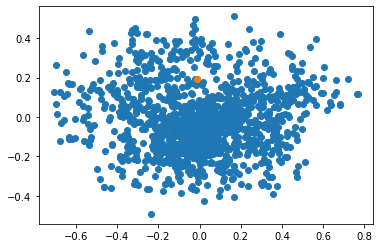

In [59]:
d2 = pca_2.transform(data)
d34 = pca_2.transform(latent_vectors[32])
plt.scatter(d2[:,0], d2[:,1])
plt.scatter(d34[0,0], d34[0,1])

In [60]:
np.linalg.norm(pca_2.inverse_transform(d34).squeeze() - latent_vectors[32].squeeze().numpy())

0.2936492355428419

In [206]:
latents = np.load('cma_sgd_cont/latent_series.npy', allow_pickle=True).squeeze()
latent_loss = np.load('cma_sgd_cont/phy_loss_plot.npy', allow_pickle=True)
latent_math_loss = np.load('cma_sgd_cont/math_loss_plot.npy')

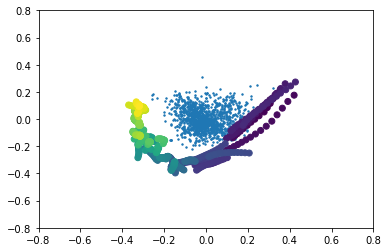

In [207]:
plot_map(latents, data, latents)

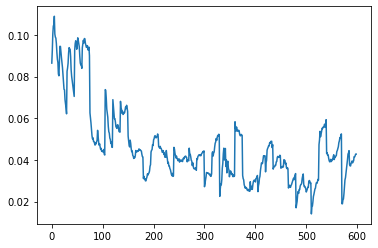

In [208]:
plt.plot(latent_loss)

In [202]:
#m = visual_Mesh_simple(torch.tensor(X[15], dtype=torch.float).cuda(), 256)
#m.show()

In [20]:
#m.export("../cma_mesh.ply")

In [70]:
X_reg = np.load('cma_reg_res10.npy')

In [201]:
#m_reg = visual_Mesh_simple(torch.tensor(X_reg[2], dtype=torch.float).cuda(), 256)
#m_reg.show()

In [75]:
#m.export("../cma_reg_mesh.ply")

In [21]:
#func2d(data[32].numpy())

In [22]:
#func2d(X[15])

In [73]:
nei_reg = neighbour(torch.tensor(X_reg[0], dtype=torch.float).cuda())

[[  32  300  476  165  806  172  167 1034  240  867]]


In [43]:
np.linalg.svd(lat)[1].round(2)

array([6.31, 1.71, 0.32, 0.1 , 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
      dtype=float32)

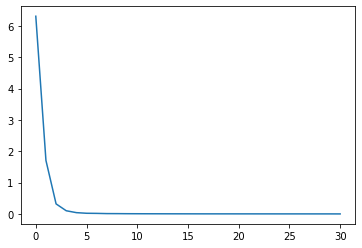

In [40]:
plt.plot(np.linalg.svd(lat)[1])

In [154]:
lat = np.load('../Compare_optimisers/new_cma_sgd/sgd.npy', allow_pickle=True)
lat.shape

(1, 256)

In [157]:
torch.svd(data_avg)[1][:50]

tensor([9.3070, 6.0962, 5.4341, 4.0013, 3.8534, 3.7064, 3.5134, 3.4274, 3.2921,
        3.1720, 3.0117, 2.8931, 2.8383, 2.7051, 2.6432, 2.5446, 2.5109, 2.4517,
        2.3896, 2.3602, 2.2530, 2.2108, 2.1709, 2.1345, 2.1049, 2.0788, 2.0565,
        2.0061, 1.9884, 1.9481, 1.9216, 1.9035, 1.8857, 1.8627, 1.8396, 1.8138,
        1.7794, 1.7392, 1.7348, 1.7326, 1.7125, 1.6839, 1.6790, 1.6639, 1.6576,
        1.6504, 1.6199, 1.6051, 1.5974, 1.5892])

In [133]:
vh = torch.svd(data_avg)[2]

In [150]:
for i in range(0, 10):
    print(np.linalg.norm(pca_2_avg.inverse_transform( pca_2_avg.transform(vh[:,i].reshape(1,-1))).reshape(1,-1) -  vh[:,i].numpy()))

3.7101536861717333e-07
1.0316497160270332e-06
0.9999997298682647
0.9999997091539955
1.0000001420722884
0.9999998808113308
0.9999998061574698
0.9999997363144434
0.999999566614878
0.9999998457648387


In [153]:
 pca_2_avg.transform(vh[:,2].reshape(1,-1)) 

array([[1.87813779e-08, 6.94075263e-07]])

In [18]:



pca_2 = PCA(n_components=2)
pca_2.fit(data)
pca_back = pca_2.transform(data)



In [ ]:

X = np.load('cma_lib_res10.npy')
X2d = pca_2.transform(X)

In [85]:
data_avg = data - data.mean(dim=0)

In [89]:
pca_2_avg = PCA(n_components=2)
pca_2_avg.fit(data_avg)
pca_back_g = pca_2_avg.transform(data_avg)

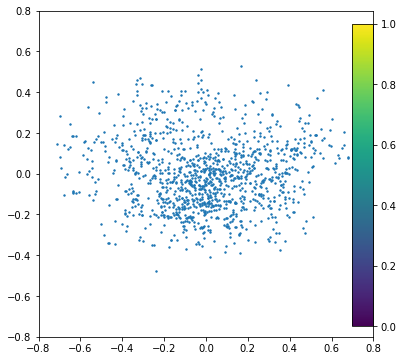

In [90]:
fig = plt.figure(figsize=(6,6))
plt.ylim([-0.8, 0.8])
plt.xlim([-0.8, 0.8])
plt.scatter(pca_back_g[:,0], pca_back_g[:,1], s=2)
#plt.scatter(pca_cma_res[:,0], pca_cma_res[:,1], marker='x', c=cma_phy)
#plt.scatter(lat2d[:,0], lat2d[:, 1])
#plt.scatter(pca_result_3[:,0], pca_result_3[:,1], marker='x', c=latent_loss)
#plt.scatter(pca_cma_sgd_dif_res[:,0], pca_cma_sgd_dif_res[:,1], marker='x', c=cma_sgd_dif_phy, s = 10)
#plt.scatter(pca_sgd_res[:,0], pca_sgd_res[:,1], marker='x', c=sgd_phy, s = 10)
#plt.scatter(pca_result_932[:,0], pca_result_932[:,1], marker='D', c=latent_loss_932[:]) #latent_loss_932[:]
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

plt.colorbar(cax=cbar_ax)


In [92]:
np.argmax(pca_back_g[:,0])

1112

In [94]:
np.argmin(pca_back_g[:,0])

563

In [95]:
pca_back_g[1112]

array([0.76753878, 0.13422766])

In [96]:
pca_back_g[563]

array([-0.70970389,  0.14355005])

In [97]:
torch.norm(data[1112] - data[563])

tensor(1.6496)

## SGD

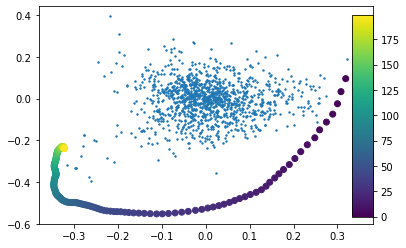

In [30]:
sgd_latent = np.load("../Compare_optimisers/SGD/latent_series.npy", allow_pickle=True)
lats = [a for a in sgd_latent]
lats = torch.stack(lats).squeeze().detach().cpu().numpy()
plot_map(lats, data, lats)

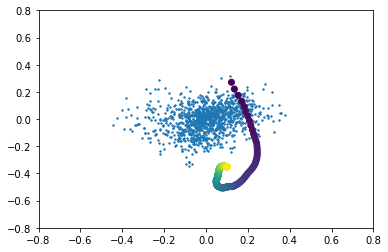

In [160]:
plot_map(lats, data, sgd_latent)

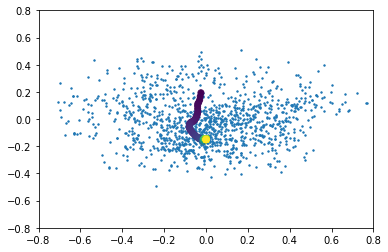

In [150]:
plot_map(lats, data, data.numpy())

In [31]:
ana = post_ana()
ana.print_neighbour(lats[-1])
ana.print_penalty(lats[-1])

[[ 718 1070 1138   17  439  461  466  350  581  181]]
[[0.5155405  0.53514465 0.53858947 0.54244267 0.56961323 0.5787163
  0.62837173 0.63493653 0.6428616  0.64588622]]
0.1166420578956604


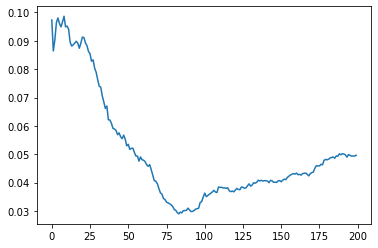

In [59]:
sgd_phy = np.load("../Compare_optimisers/SGD/phy_loss.npy")
plt.plot(sgd_phy)

In [53]:
np.linalg.svd(lats.reshape(-1, 256))[2][:,0].dot(np.linalg.svd(data.numpy())[2])

array([ 0.09265903,  0.01893449,  0.06151693,  0.05007777,  0.03201698,
        0.02374387, -0.01828078,  0.04476574,  0.00888401, -0.06684071,
        0.01977433,  0.01021442, -0.00354756,  0.13366544, -0.00727352,
       -0.01728433,  0.01675628, -0.00799518, -0.03153019, -0.05028152,
        0.04511812,  0.05083768, -0.05978308, -0.16221078,  0.07787509,
       -0.14178073,  0.07002465,  0.01776222,  0.09746484,  0.03432428,
       -0.01220911,  0.04966662,  0.0103238 , -0.02770054,  0.03724255,
       -0.06937639, -0.10367936, -0.08024452,  0.05311608, -0.06729729,
        0.08226976,  0.00876422,  0.00630408, -0.03026246,  0.07188382,
       -0.01801158,  0.00169347,  0.02507254, -0.03860258, -0.0466966 ,
        0.0413263 ,  0.05476963,  0.02207917,  0.03511879, -0.02733504,
        0.06078008,  0.01609864, -0.04696776,  0.12457342, -0.01024097,
       -0.04801323, -0.10804738, -0.03259389, -0.04875587,  0.02425198,
       -0.02724046,  0.05322907, -0.0141992 ,  0.04810394, -0.07

# SGD - const lr

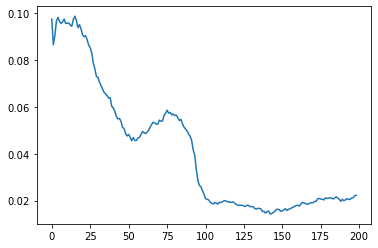

In [65]:
sgd_c_phy = np.load("../Compare_optimisers/SGD_const_lr/phy_loss.npy", allow_pickle=True)
plt.plot(sgd_c_phy)

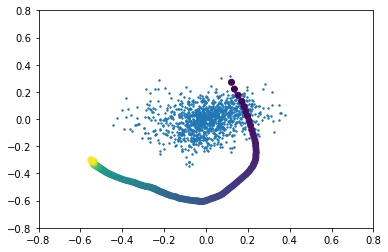

In [151]:
sgd_latent = np.load("../Compare_optimisers/SGD_const_lr/latent_series.npy", allow_pickle=True)
sgd_latent = sgd_latent.squeeze()
plot_map(sgd_latent, data, sgd_latent)

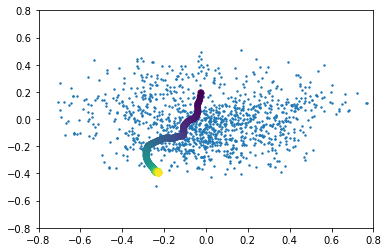

In [152]:
plot_map(sgd_latent, data, data.numpy())

## CMA-SGD

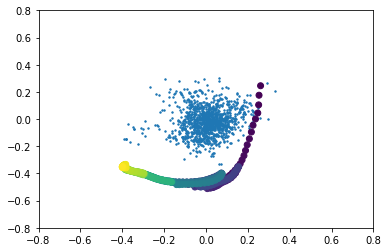

In [153]:
cma_sgd = np.load("../Compare_optimisers/CMASGD/latent_series.npy").squeeze()
plot_map(cma_sgd, data, cma_sgd)

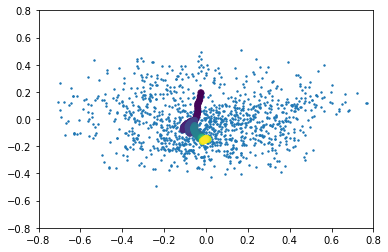

In [154]:
plot_map(cma_sgd, data, data.numpy())

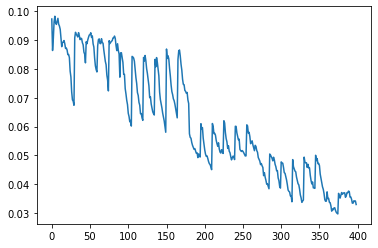

In [15]:
cma_sgd_phy = np.load("../Compare_optimisers/CMASGD/phy_loss.npy")
plt.plot(cma_sgd_phy)

# CMA 

(-0.8, 5.0)

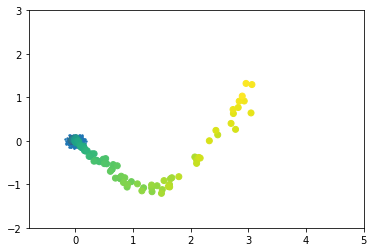

In [161]:
cma_latent = np.load("../Compare_optimisers/CMA_5_200/latent_series.npy", allow_pickle=True)
cma_latent = cma_latent.squeeze()
plot_map(cma_latent, data, cma_latent)
plt.ylim([-2, 3])
plt.xlim([-0.8, 5])

In [55]:
ana = post_ana()
#ana.plot_Mesh(cma_latent[-10,:]).show()

In [56]:
ana.print_penalty(cma_latent[-1,:])
ana.print_neighbour(cma_latent[-1,:])

0.7725865840911865
[[164 859  21 293 260 214 447 106 217 881]]
[[3.82642556 3.85778828 3.85799882 3.86024032 3.86445336 3.86695397
  3.87223378 3.87257989 3.87428997 3.87636639]]


In [96]:
latent = torch.tensor(cma_latent[-1,:], dtype=torch.float)
distances, indeces = LATENT_KD_TREE.query(latent.cpu().detach().reshape(1,-1), k=10)
print(0.1 * torch.sum((latent - latent_vectors.squeeze()[indeces.squeeze()]) ** 2, dim=1).mean().item())

1.4922441482543947


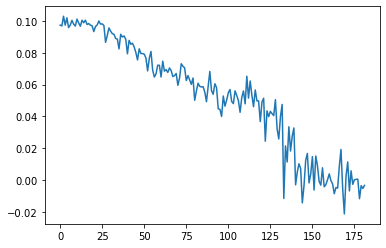

In [104]:
cma_phy = np.load("../Compare_optimisers/CMA_5_200/phy_loss.npy")
plt.plot(cma_phy)

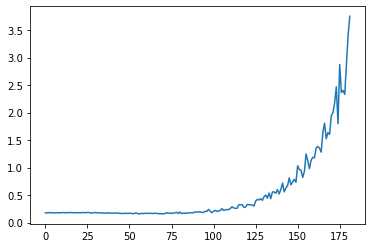

In [105]:
cma_math = np.load("../Compare_optimisers/CMA_5_200/math_loss.npy")
plt.plot(cma_math)

# CMA20

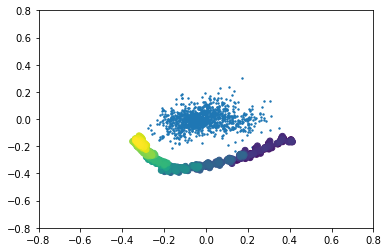

In [133]:
cma_latent = np.load("../Compare_optimisers/CMA_cluster20/latent_series.npy", allow_pickle=True)
cma_latent = cma_latent.squeeze()
plot_map(cma_latent, data)


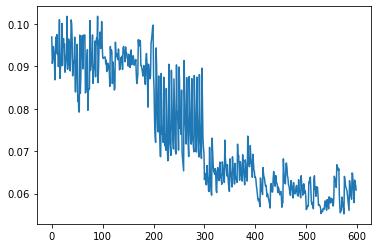

In [63]:
cma_phy = np.load("../Compare_optimisers/CMA_cluster20/phy_loss.npy")
plt.plot(cma_phy)

# CMA - n=5, iter=200

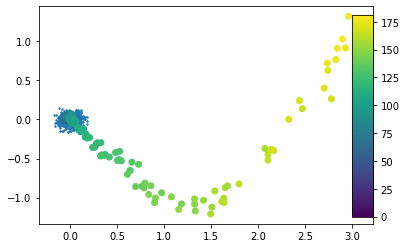

In [22]:
cma_latent = np.load("../Compare_optimisers/CMA_5_200/latent_series.npy", allow_pickle=True)
cma_latent = cma_latent.squeeze()
plot_map(cma_latent, data, cma_latent)

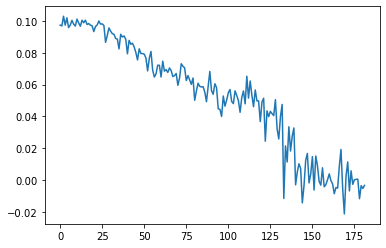

In [24]:
cma_phy = np.load("../Compare_optimisers/CMA_5_200/phy_loss.npy", allow_pickle=True)
plt.plot(cma_phy)

# CMA-SGD dif loc 

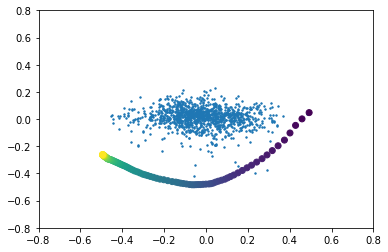

In [173]:
cma_latent = np.load("../Compare_optimisers/CMASGD_dif_loc//latent_series.npy", allow_pickle=True)
cma_latent = cma_latent.squeeze()
plot_map(cma_latent, data, cma_latent)

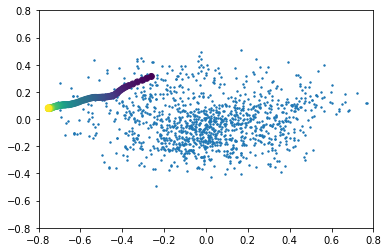

In [175]:
plot_map(cma_latent, data, data.numpy())

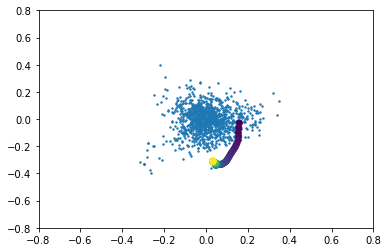

In [176]:
plot_map(cma_latent, data, lats)

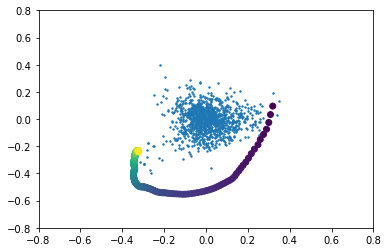

In [177]:
plot_map(lats, data, lats)

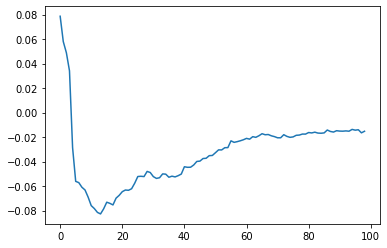

In [174]:
cma_sgd_dif_phy = np.load("../Compare_optimisers/CMASGD_dif_loc/phy_loss.npy")
plt.plot(cma_sgd_dif_phy)

In [102]:
#visual_Mesh(torch.tensor(cma_latent[15]).cuda(), 256).show()
#latent loss. -0.074072 

# Adam 

(-3.0, 3.0)

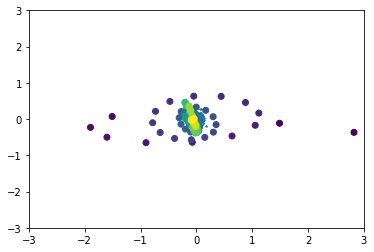

In [184]:
adam_latent = np.load("../Compare_optimisers/Adam/latent_series.npy", allow_pickle=True)
adam_latent = [a for a in adam_latent]
adam_latent = torch.stack(adam_latent).squeeze().detach().cpu().numpy()
plot_map(adam_latent, data, adam_latent)
plt.ylim([-3, 3])
plt.xlim([-3, 3])

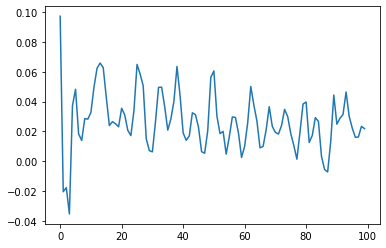

In [51]:
adam_phy = np.load("../Compare_optimisers/Adam/phy_loss.npy")
plt.plot(adam_phy)

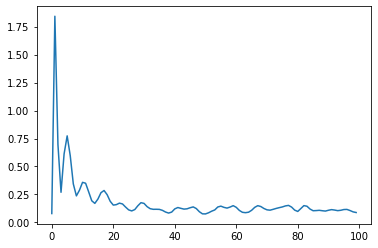

In [54]:
adam_math = np.load("../Compare_optimisers/Adam/math_loss.npy")
plt.plot(adam_math)

# CMA Line search

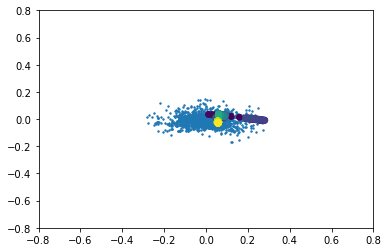

In [198]:
cmaln_latent = np.load("../Compare_optimisers/CMALN/latent_series.npy", allow_pickle=True)
cmaln_latent = cmaln_latent.squeeze()
plot_map(cmaln_latent, data, cmaln_latent)

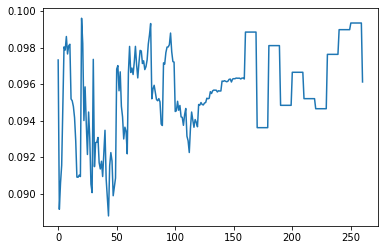

In [59]:
cmaln_phy = np.load("../Compare_optimisers/CMALN/phy_loss.npy")
plt.plot(cmaln_phy)

# new cma

In [7]:
cma_new_latent_reg = np.load("../Compare_optimisers/new_cma/cma_withReg_dif_loc32PCA.npy", allow_pickle=True)
cma_new_latent_reg = cma_new_latent_reg.squeeze()
#plot_map(cmaln_latent, data, cmaln_latent)

In [18]:
cma_new_latent_reg.shape

(15, 12, 256)

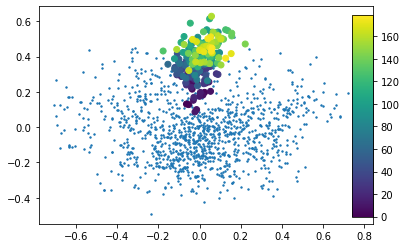

In [8]:
plot_map(cma_new_latent_reg.reshape(-1, 256), data, data.numpy())

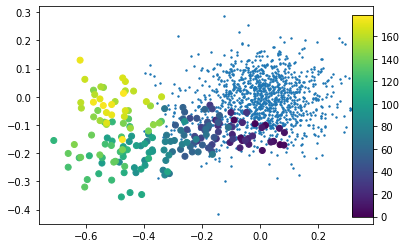

In [9]:
plot_map(cma_new_latent_reg.reshape(-1, 256), data, cma_new_latent_reg.reshape(-1, 256))

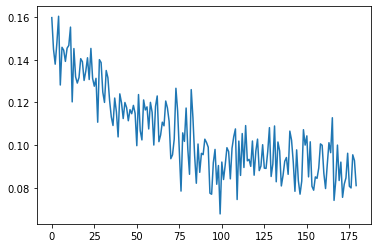

In [10]:
cma_new_loss_reg = np.load("../Compare_optimisers/new_cma/cma_fitness_withReg_dif_loc32PCA.npy", allow_pickle=True)
plt.plot(cma_new_loss_reg.ravel())

In [12]:
for i in range(12):
    print(i, cma_new_loss_reg[-1,i] - func2d(cma_new_latent_reg[-1, i]))

0 0.01417366065191046
1 0.0066680601367554715
2 0.007348408951606822
3 -0.010228278215640818
4 0.006377853183957782
5 0.006494882606537161
6 -0.01416024529225618
7 0.007460896244561227
8 -0.012244572155677674
9 0.016337040464898256
10 0.015247633360987334
11 0.015789157507727927


In [67]:
cma_recover.shape

(15, 17, 256)

In [20]:
np.save("../Compare_optimisers/new_cma/negative_similar.npy", cma_new_latent_reg[-1, 8])

In [25]:
np.save("../Compare_optimisers/new_cma/original126_similar.npy", latent_vectors[126].numpy())

In [14]:
ana = post_ana()
ana.print_neighbour(cma_new_latent_reg[-1, 0])
ana.print_penalty(cma_new_latent_reg[-1, 0])

[[ 126  731  516  133 1051  237   58  911  796 1117]]
[[0.56493486 0.60042482 0.61693803 0.65933838 0.67637257 0.67867402
  0.68160262 0.68202982 0.68789701 0.69052109]]
0.08585695028305054


In [22]:
#ana.plot_Mesh(cma_new_latent_reg[-1, 8]).export("../Compare_optimisers/new_cma/negative_similar.ply")

In [24]:
#ana.plot_Mesh(latent_vectors[126].numpy()).export("../Compare_optimisers/new_cma/original_similar.ply")

In [66]:
cma_recover = []
for i in cma_new_latent_reg:
    cma_recover.append(pca_2.inverse_transform(i))
cma_recover = np.array(cma_recover)

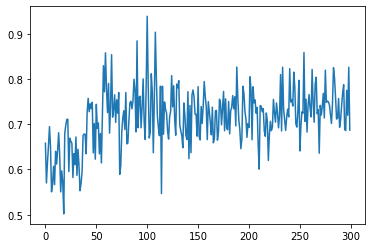

In [11]:
cma_new_loss_reg = np.load("../Compare_optimisers/new_cma/cma_fitness_withReg_dif_loc522L.npy", allow_pickle=True)
plt.plot(cma_new_loss_reg.ravel())

In [71]:
ana = post_ana()
ana.print_neighbour(cma_recover[-1, 0])
ana.print_penalty(cma_recover[-1, 0])

[[ 731  126  729 1117  237  911  330 1051   58   32]]
[[0.77851268 0.78570792 0.79944005 0.81888215 0.82086877 0.82330654
  0.82780506 0.83483139 0.8390834  0.84302205]]
0.13363404273986818


In [79]:
#ana.plot_Mesh(cma_recover[-1, 6]).show()

In [83]:
torch.svd(latent_vectors.squeeze())[1]

tensor([9.3074, 6.1328, 5.5206, 4.3038, 4.0011, 3.7646, 3.5415, 3.4368, 3.2925,
        3.1745, 3.0145, 2.8932, 2.8500, 2.7523, 2.6691, 2.5479, 2.5120, 2.4533,
        2.3943, 2.3633, 2.2534, 2.2126, 2.1715, 2.1365, 2.1291, 2.0965, 2.0583,
        2.0267, 2.0050, 1.9585, 1.9216, 1.9054, 1.8893, 1.8771, 1.8622, 1.8158,
        1.7795, 1.7439, 1.7390, 1.7326, 1.7178, 1.6963, 1.6801, 1.6652, 1.6585,
        1.6506, 1.6241, 1.6055, 1.5975, 1.5893, 1.5789, 1.5704, 1.5666, 1.5415,
        1.5296, 1.5180, 1.5124, 1.5071, 1.5018, 1.4912, 1.4796, 1.4610, 1.4480,
        1.4429, 1.4345, 1.4306, 1.4200, 1.4146, 1.4116, 1.4034, 1.3968, 1.3876,
        1.3811, 1.3733, 1.3672, 1.3620, 1.3493, 1.3422, 1.3409, 1.3336, 1.3270,
        1.3233, 1.3159, 1.3101, 1.2999, 1.2951, 1.2908, 1.2873, 1.2815, 1.2733,
        1.2656, 1.2597, 1.2587, 1.2526, 1.2482, 1.2438, 1.2401, 1.2299, 1.2258,
        1.2209, 1.2119, 1.2103, 1.2039, 1.2001, 1.1975, 1.1934, 1.1856, 1.1791,
        1.1785, 1.1758, 1.1698, 1.1647, 

In [64]:
data_avg = latent_vectors - latent_vectors.mean(dim=0)
pca_2 = PCA(n_components=106)
pca_2.fit(data_avg.cpu().numpy().squeeze())

PCA(n_components=106)

In [11]:
cma_new_latent_reg = np.load("../Compare_optimisers/new_cma/cma_withReg_dif_loc522L.npy", allow_pickle=True)
cma_new_latent_reg = cma_new_latent_reg.squeeze()
#plot_map(cmaln_latent, data, cmaln_latent)

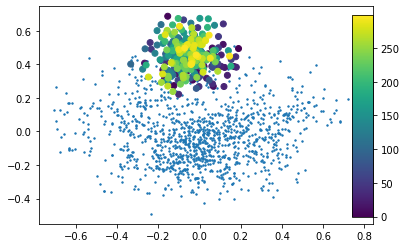

In [12]:
plot_map(cma_new_latent_reg.reshape(-1, 256), data, data.numpy())

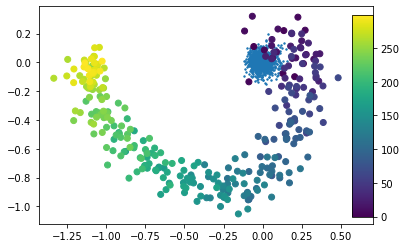

In [13]:
plot_map(cma_new_latent_reg.reshape(-1, 256), data, cma_new_latent_reg.reshape(-1, 256))

In [29]:
ana.print_neighbour(latent_vectors[522].numpy())

[[ 522  671 1117  126 1141  729  731   32   84  237]]
[[0.         0.42291313 0.6673053  0.70821791 0.75916462 0.76455684
  0.76574969 0.78074293 0.78399085 0.7871853 ]]


In [14]:
ana = post_ana()
ana.print_neighbour(cma_new_latent_reg[-1, 0])
ana.print_penalty(cma_new_latent_reg[-1, 0])

[[ 126 1117  522  380  690   42  731  191  671  288]]
[[1.8913946  1.89970814 1.91377804 1.91708489 1.92050372 1.923628
  1.928186   1.92856898 1.93089754 1.93298112]]
0.7362953186035157


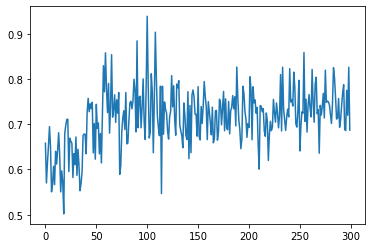

In [15]:
cma_new_loss_reg = np.load("../Compare_optimisers/new_cma/cma_fitness_withReg_dif_loc522L.npy", allow_pickle=True)
plt.plot(cma_new_loss_reg.ravel())

In [26]:
for i in range(20):
    print(i, cma_new_loss_reg[0,i] - func2d(cma_new_latent_reg[0, i]))

0 0.02593334478954945
1 0.04637217839974539
2 0.046891924848246225
3 0.05372070523922379
4 0.04708413391246269
5 0.0457654485750123
6 0.016031492115820556
7 0.009699482768087297
8 0.019532334266770923
9 0.031110887365622175
10 0.039884060459285164
11 0.03851125209957196
12 0.013018572217408875
13 -0.0004931322816225103
14 0.03518654365144491
15 0.04095872583005311
16 0.05419338885838587
17 0.008890247478924418
18 0.05522724651013344
19 0.07927827566970169


In [25]:
#ana.plot_Mesh(latent_vectors[522].cpu().detach().numpy()).show()

In [24]:
#ana.plot_Mesh(cma_new_latent_reg[-1, 10]).show()

In [41]:
cma_new_latent_reg = np.load("../Compare_optimisers/new_cma/cma_withReg_dif_loc424.npy", allow_pickle=True)
cma_new_latent_reg = cma_new_latent_reg.squeeze()
#plot_map(cmaln_latent, data, cmaln_latent)

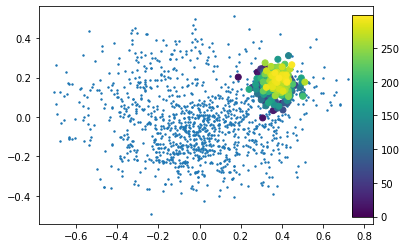

In [42]:
plot_map(cma_new_latent_reg.reshape(-1, 256), data, data.numpy())

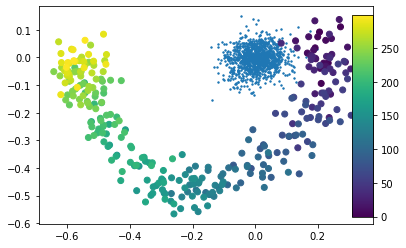

In [43]:
plot_map(cma_new_latent_reg.reshape(-1, 256), data, cma_new_latent_reg.reshape(-1, 256))

In [44]:
ana = post_ana()
ana.print_neighbour(cma_new_latent_reg[-1, 0])
ana.print_penalty(cma_new_latent_reg[-1, 0])

[[ 424  732  178  612   22  529  249 1005  947  614]]
[[1.04319535 1.09637658 1.1002689  1.11061339 1.11423265 1.11693537
  1.12026114 1.13419076 1.13435987 1.13841932]]
0.24695107936859131


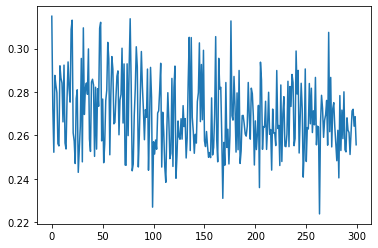

In [45]:
cma_new_loss_reg = np.load("../Compare_optimisers/new_cma/cma_fitness_withReg_dif_loc424.npy", allow_pickle=True)
plt.plot(cma_new_loss_reg.ravel())

In [49]:
#ana.plot_Mesh(cma_new_latent_reg[-1, 9]).show()

In [48]:
#ana.plot_Mesh(latent_vectors[424].cpu().detach().numpy()).show()

In [52]:
for i in range(20):
    print(i, cma_new_loss_reg[0,i] - func2d(cma_new_latent_reg[0, i]))

0 0.07867343235972324
1 0.056141163317981135
2 0.026334947743151704
3 0.05005529496996422
4 0.044045985914323516
5 0.04613714294034307
6 0.03571966940578289
7 0.03795989253256432
8 0.06865830624073074
9 0.05900316494279212
10 0.0572969383922218
11 0.044512302832163175
12 0.045324826719355726
13 0.03694511565805286
14 0.038107039335271625
15 0.050131634540436065
16 0.08335205930720424
17 0.05178483567797504
18 0.05369644323545411
19 0.057787344170915245


In [7]:
cma_new_latent_reg = np.load("../Compare_optimisers/new_cma/cma_withReg_dif_loc92.npy", allow_pickle=True)
cma_new_latent_reg = cma_new_latent_reg.squeeze()
#plot_map(cmaln_latent, data, cmaln_latent)

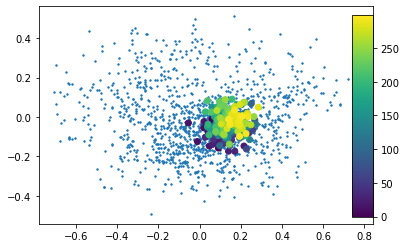

In [8]:
plot_map(cma_new_latent_reg.reshape(-1, 256), data, data.numpy())

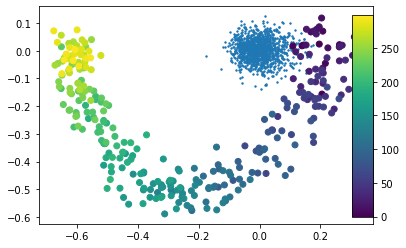

In [9]:
plot_map(cma_new_latent_reg.reshape(-1, 256), data, cma_new_latent_reg.reshape(-1, 256))

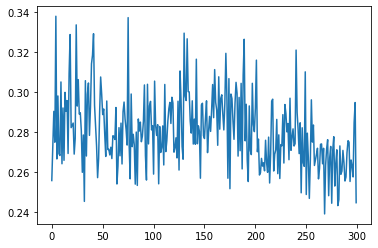

In [10]:
cma_new_loss_reg = np.load("../Compare_optimisers/new_cma/cma_fitness_withReg_dif_loc92.npy", allow_pickle=True)
plt.plot(cma_new_loss_reg.ravel())

In [17]:
cma_new_loss_reg[0]

array([0.25571918, 0.27399692, 0.29029626, 0.27488494, 0.3378582 ,
       0.26651579, 0.2980006 , 0.26914853, 0.26823509, 0.30500194,
       0.26410714, 0.29200482, 0.26583731, 0.29980186, 0.29031879,
       0.29567891, 0.26924524, 0.30908886, 0.32870954, 0.28216743])

In [38]:
for i in range(20):
    print(i, cma_new_loss_reg[-1,i] - func2d(cma_new_latent_reg[-1, i]))

0 0.003146211141213051
1 0.002778318443515171
2 0.018506745779935135
3 0.010889111631529225
4 0.02377110185659695
5 0.011460039597003063
6 0.006528238202526293
7 0.008215203128909387
8 0.004856137938850813
9 -0.00045593489466205783
10 0.0017040084483324058
11 0.006967108043795911
12 0.0031061661413723796
13 0.009047193168393475
14 0.008813520826031762
15 0.004425060442788953
16 0.003861466434842531
17 0.013592377975056802
18 0.023257233952999
19 0.0019549304407142087


In [21]:
ana = post_ana()
ana.print_neighbour(cma_new_latent_reg[-1, 0])
ana.print_penalty(cma_new_latent_reg[-1, 0])

[[  92   17  177  410  718  732 1135  368  187  558]]
[[1.11678236 1.14890575 1.15584623 1.15597123 1.16161231 1.1626185
  1.16628989 1.1681157  1.16822843 1.16902156]]
0.2679311513900757


In [15]:
#ana.plot_Mesh(latent_vectors[92].cpu().detach().numpy()).show()

In [40]:
#ana.plot_Mesh(cma_new_latent_reg[-1, 9]).show()

In [6]:
cma_new_latent_reg = np.load("../Compare_optimisers/new_cma/cma_withReg_dif_loc254.npy", allow_pickle=True)
cma_new_latent_reg = cma_new_latent_reg.squeeze()
#plot_map(cmaln_latent, data, cmaln_latent)

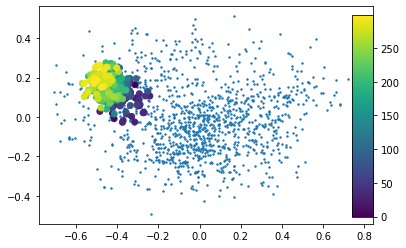

In [9]:
plot_map(cma_new_latent_reg.reshape(-1, 256), data, data.numpy())

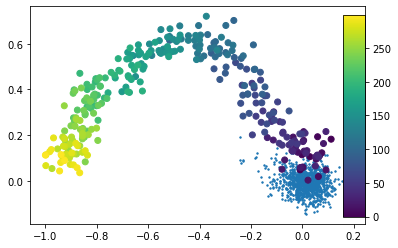

In [10]:
plot_map(cma_new_latent_reg.reshape(-1, 256), data, cma_new_latent_reg.reshape(-1, 256))

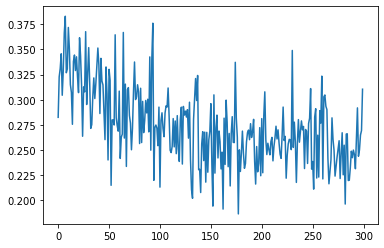

In [11]:
cma_new_loss_reg = np.load("../Compare_optimisers/new_cma/cma_fitness_withReg_dif_loc254.npy", allow_pickle=True)
plt.plot(cma_new_loss_reg.ravel())

In [12]:
ana = post_ana()
ana.print_neighbour(cma_new_latent_reg[-1, 0])
ana.print_penalty(cma_new_latent_reg[-1, 0])

[[ 254  366  840  696  856  342  387  572  599 1166]]
[[1.25858803 1.35204285 1.36113278 1.3620818  1.41057388 1.42397096
  1.4448902  1.459714   1.47966078 1.48963622]]
0.28084583282470704


In [14]:
#ana.plot_Mesh(cma_new_latent_reg[-1, 0]).show()

In [32]:
cma_new_latent_reg = np.load("../Compare_optimisers/new_cma/cma_withReg.npy", allow_pickle=True)
cma_new_latent_reg = cma_new_latent_reg.squeeze()
#plot_map(cmaln_latent, data, cmaln_latent)

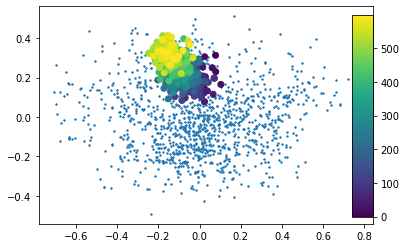

In [33]:
plot_map(cma_new_latent_reg.reshape(-1, 256), data, data.numpy())

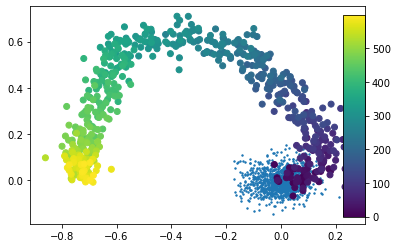

In [34]:
plot_map(cma_new_latent_reg.reshape(-1, 256), data, cma_new_latent_reg.reshape(-1, 256))

In [49]:
np.linalg.svd(cma_new_latent_reg.reshape(-1, 256))[2][:,0].dot(np.linalg.svd(data.numpy())[2])

array([-0.00734661, -0.06080595, -0.06858777, -0.03073413,  0.02849114,
        0.01439394,  0.03263222,  0.0239783 , -0.05775838,  0.0883436 ,
       -0.07973242, -0.02985938,  0.06278491,  0.12282759, -0.12920054,
       -0.00368788, -0.06449225,  0.02830109,  0.11522026,  0.04466751,
        0.03946627,  0.00946107,  0.02701429,  0.1161485 ,  0.0192809 ,
       -0.08885136,  0.06981166,  0.01094508, -0.04232643,  0.04781717,
        0.06125272,  0.09786469,  0.05790227, -0.00290722, -0.1114459 ,
       -0.01282928, -0.0092025 ,  0.08913554,  0.00862723, -0.09663832,
        0.06620375,  0.00108699,  0.05292796,  0.10841398,  0.00027439,
       -0.01310032,  0.0119076 ,  0.08023885, -0.01512769, -0.02326999,
       -0.10928102, -0.05772327,  0.06303191,  0.04532253,  0.1067665 ,
       -0.0847325 ,  0.07826405,  0.12843896, -0.01873666, -0.12183084,
       -0.04795576, -0.0418222 ,  0.07911897,  0.02596852, -0.05832003,
        0.06746642,  0.01435429, -0.00544036,  0.05117089,  0.02

In [44]:
np.linalg.svd(cma_new_latent_reg.reshape(-1, 256))[2][:,0]

array([ 0.04293904,  0.03022678, -0.00603946,  0.11593063, -0.00241979,
        0.05033602,  0.10566059, -0.03360213,  0.02164568, -0.00335379,
        0.02159071, -0.05440049,  0.02351793, -0.08972784,  0.05017956,
       -0.06132973,  0.00980421, -0.11455068,  0.07640625, -0.00105645,
        0.03578544, -0.07152703, -0.01641089,  0.06436543, -0.03315143,
        0.00970653,  0.16244459,  0.01628859, -0.02637298,  0.02192026,
       -0.02172009,  0.02544649, -0.13802364,  0.0064464 , -0.02064513,
        0.00863585, -0.05634881,  0.03573898, -0.01825168,  0.07044028,
       -0.02237552,  0.0928148 , -0.04456057,  0.01684639, -0.02298899,
        0.04912671, -0.02871162,  0.03914243, -0.10536789, -0.04363201,
        0.06715984, -0.0187501 ,  0.06805666,  0.23958688, -0.04311088,
        0.12614046,  0.04077971, -0.09758243, -0.03754836,  0.06321498,
        0.01691318, -0.07069815, -0.03715832,  0.0603529 ,  0.02893973,
       -0.06550601,  0.06600138,  0.08078296, -0.00933176, -0.03

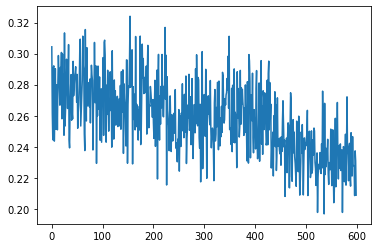

In [35]:
cma_new_loss_reg = np.load("../Compare_optimisers/new_cma/cma_fitness_withReg.npy", allow_pickle=True)
plt.plot(cma_new_loss_reg.ravel())

In [38]:
ana = post_ana()
ana.print_neighbour(cma_new_latent_reg[-1, 0])
ana.print_penalty(cma_new_latent_reg[-1, 0])

[[  32  126  516  729  133  753  731 1004  213   29]]
[[1.1605189  1.16935561 1.18249463 1.20246829 1.2174877  1.22021521
  1.22060021 1.22540415 1.23362696 1.23944329]]
0.24143226146698


In [36]:
def func2d(latent):
    distances, indeces = LATENT_KD_TREE.query(latent.cpu().detach().reshape(1,-1), k=10)
    return 0.2 * torch.sum((latent - latent_vectors.squeeze()[indeces.squeeze()]) ** 2, dim=1).mean() 

In [37]:
func2d(torch.tensor(cma_new_latent_reg[-1, 0], dtype=torch.float))

tensor(0.2916)

In [41]:
#ana.plot_Mesh(cma_new_latent_reg[-1, 0]).show()

In [40]:
cma_new_latent_reg.shape

(30, 20, 256)

# bad regularisation

In [89]:
cma_new_latent = np.load("../Compare_optimisers/new_cma/cma_withReg.npy", allow_pickle=True)
cma_new_latent = cma_new_latent.squeeze()
#plot_map(cmaln_latent, data, cmaln_latent)

In [90]:
cma_new_latent.shape

(10, 20, 256)

In [57]:
ana = post_ana()
ana.print_neighbour(cma_new_latent[9, 0])
ana.print_penalty(cma_new_latent[9, 0])

[[ 32 731 126 326 911 777  42  29 516 790]]
[[1.27571477 1.30483117 1.31543783 1.3276892  1.33254132 1.33382244
  1.34250061 1.34401948 1.34738562 1.35582694]]
0.2655953884124756


In [19]:
#ana.plot_Mesh(cma_new_latent[9, 0]).show()

In [88]:
!nvidia-smi

Wed Sep  9 00:00:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:44:00.0 Off |                  N/A |
| 27%   40C    P8    27W / 189W |    375MiB /  6083MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:45:00.0 Off |                  N/A |
| 28%   43C    P8    32W / 189W |    365MiB /  6083MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [119]:
#ana.plot_Mesh(cma_new_latent[0, 16]).show()#.export('../Compare_optimisers/new_cma/meshes/199.ply')

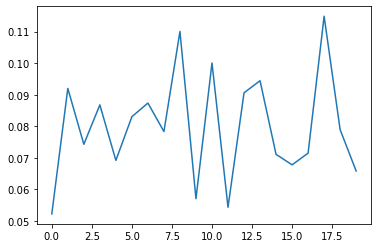

In [109]:
plt.plot(cma_new_loss[0,:])

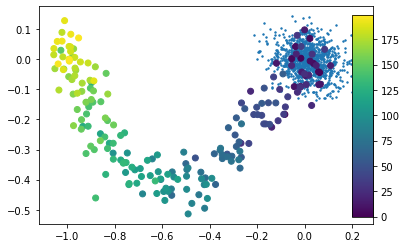

In [11]:
plot_map(cma_new_latent.reshape(-1, 256), data, cma_new_latent.reshape(-1, 256))

In [92]:
write_Mesh(cma_new_latent.reshape(-1,256), "../Compare_optimisers/new_cma/meshes/")

In [91]:
mkdir ../Compare_optimisers/new_cma/meshes

In [13]:
cma_new_loss = np.load("../Compare_optimisers/new_cma/cma_fitness_withReg.npy", allow_pickle=True)

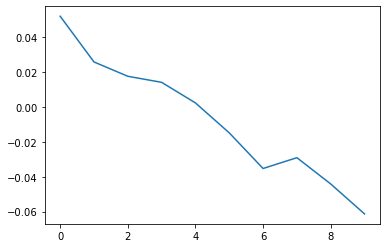

In [14]:
plt.plot(np.min(cma_new_loss, axis=1))

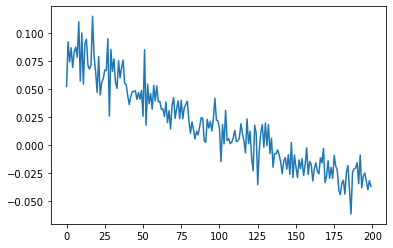

In [15]:
plt.plot(cma_new_loss.ravel())

In [16]:
cma_new_loss[0,:]

array([0.05220511, 0.09198961, 0.07427456, 0.08676965, 0.06917379,
       0.08302145, 0.08735155, 0.07832088, 0.11004993, 0.05703132,
       0.10005311, 0.05431741, 0.09060061, 0.09442665, 0.07109356,
       0.06776322, 0.07147979, 0.11487228, 0.07890415, 0.06581452])

#  new cma sgd

In [100]:
#cma_sgd_new_loss

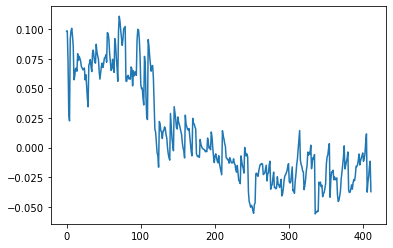

In [86]:
cma_sgd_new_loss = np.load("../Compare_optimisers/new_cma_sgd/cma_sgd_fitness_withReg_2.npy", allow_pickle=True)
plt.plot(cma_sgd_new_loss)

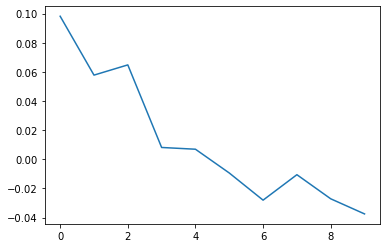

In [85]:
plt.plot(cma_sgd_new_loss[0::45])

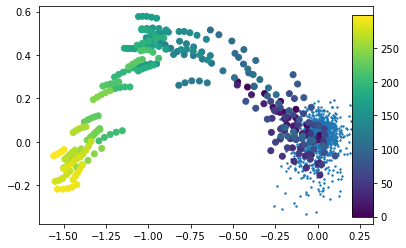

In [71]:
n = 300
plot_map(cma_sgd_new_lat[:n], data, cma_sgd_new_lat[:n])

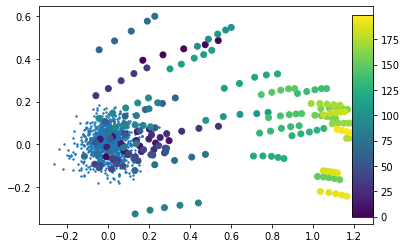

In [60]:
cma_sgd_new_lat = np.load("../Compare_optimisers/new_cma_sgd/cma_sgd_withReg_2.npy", allow_pickle=True)

plot_map(cma_sgd_new_lat[:n], data, cma_sgd_new_lat[:n])

In [67]:
ana = post_ana()
ana.print_neighbour(cma_sgd_new_lat[200])
ana.print_penalty(cma_sgd_new_lat[200])

[[ 32  20 763  39 172 771  54 380 855 581]]
[[1.36888557 1.49562558 1.5008006  1.50549372 1.50651234 1.51109641
  1.5117034  1.51222106 1.51336594 1.51345325]]
0.2987831592559815


In [63]:
cma_sgd_new_lat.shape

(411, 256)

In [77]:
#ana.plot_Mesh(cma_sgd_new_lat[120]).show()

In [87]:
def write_Mesh(latents, dire):
    if isinstance(latents, np.ndarray):
        latents = torch.tensor(latents, dtype=torch.float).cuda()
    num = latents.shape[0] - 1
    gap = int(num / 10)
    for i in range(1, 11):
        idx = i * gap
        with torch.no_grad():
            ply_mesh = create_mesh(decoder,
                                latents[idx],
                                N=128,
                                max_batch=int(2 ** 12))
            points = torch.FloatTensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                                ply_mesh['vertex']['y'][:, None], 
                                                ply_mesh['vertex']['z'][:, None]))).cuda()
            scaled_mesh = transform_mesh(points, ply_mesh, AvgTransform)
            verticies = scaled_mesh['x'].cpu().detach()
            faces = scaled_mesh['face'].t().cpu().detach()
            m = trimesh.Trimesh(vertices=verticies, faces=faces) 
            m.export(dire+ str(idx) + '.ply') 
#write_Mesh(cma_sgd_new_lat, '../Compare_optimisers/new_cma_sgd/meshes/' )

In [72]:
! mkdir ../Compare_optimisers/new_cma_sgd/meshes

In [76]:
np.linspace(0,10,11)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])